In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSSBB'
m='SNOW'

## Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
#%matplotlib inline
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=5.2.2 	required version>=6.0.0 ******* Update Version ******


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|     0|[00 00 00 00 00 0...|1985.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|    31|[00 00 00 00 00 0...|1986.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|    31|[00 00 00 00 00 0...|1988.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|     0|[00 00 00 00 00 0...|1989.0|SSSBSSBB|
|    640.1|  37.495|-119.9858|       SNOW|USC00045352|    30|[00 00 00 00 00 0...|1990.0|SSSBSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [7]:
df.count()

1890

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

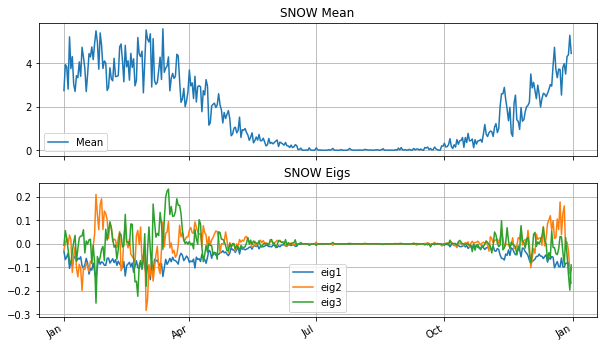

In [8]:
import pylab as plt
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

In [9]:
v=[np.array(EigVec[:,i]).flatten() for i in range(np.shape(EigVec)[1])]

### plot the percent of residual variance on average

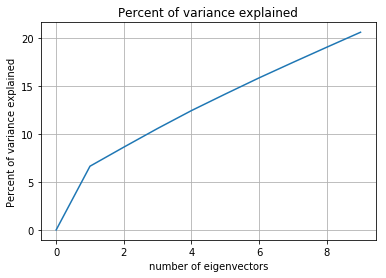

In [10]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=np.cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [11]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [12]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
#print 'before filter',df2.count()
#df3=df2.filter(df2.res_mean<1)
#print 'after filter',df3.count()

In [13]:
# Sort entries by increasing values of ers_3
df3=df2.sort(df2.res_3,ascending=True)

In [14]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            #_title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
            #        %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],interactive=False)
    return None


#### Different things to try
The best/worst rows in terms of res_mean,res_1, res_2, res_3

The rows with the highest lowest levels of coeff1, coeff2, coeff3, when the corresponding residue is small.

In [15]:
df4=df3.filter(df3.res_1<0.4).sort(df3.coeff_1)
#df4=df3.filter(df3.elevation<1000).sort(df3.elevation)
rows=df4.take(12)
#print(df4.count())
df4.select('coeff_1','res_1').show(4)
#df4.select('coeff_1','elevation').show(4)

#df4=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
#rows=df4.take(12)
#df4.select('coeff_2','res_2').show(4)

+------------------+-------------------+
|           coeff_1|              res_1|
+------------------+-------------------+
|38.486635332603555|0.34452912103231037|
| 39.15110885277375| 0.3910188604563236|
| 39.22286059141141| 0.3611113255940745|
|39.240776772458815|0.33766431603806935|
+------------------+-------------------+
only showing top 4 rows



C:\Users\Sai\.conda\envs\python2\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


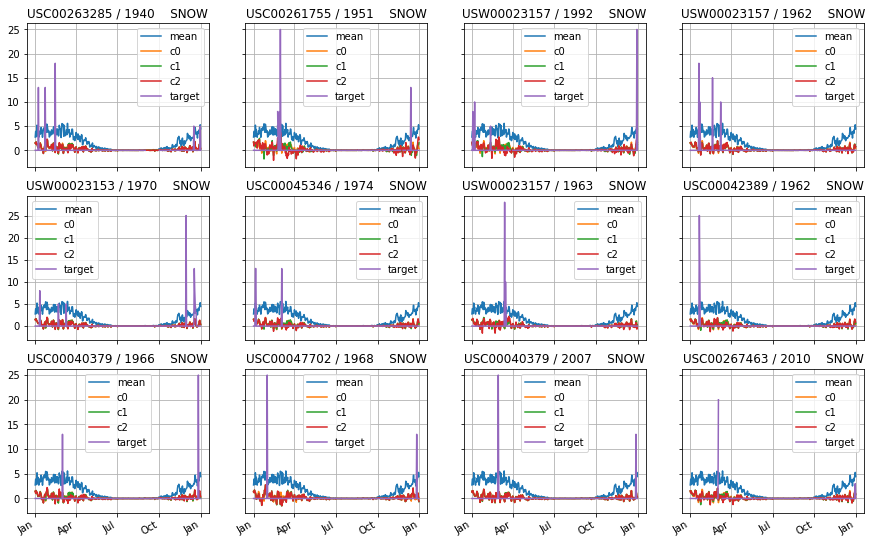

In [16]:
plot_recon_grid(rows)

In [17]:
df5=df3.filter(df3.res_1<0.4).sort(df3.coeff_1,ascending=False)
#df4=df3.filter(df3.elevation<1000).sort(df3.elevation)
rows=df5.take(12)
#print(df4.count())
df5.select('coeff_1','res_1').show(4)
#df4.select('coeff_1','elevation').show(4)
df5.count()


#df5=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
#rows=df5.take(12)
#df5.select('coeff_2','res_2').show(4)

+------------------+--------------------+
|           coeff_1|               res_1|
+------------------+--------------------+
|44.211928168544276|0.021666306542609086|
|44.211928168544276| 0.02405371072575742|
|44.211928168544276|0.023885475473784123|
|44.211928168544276| 0.02418952743888439|
+------------------+--------------------+
only showing top 4 rows



790

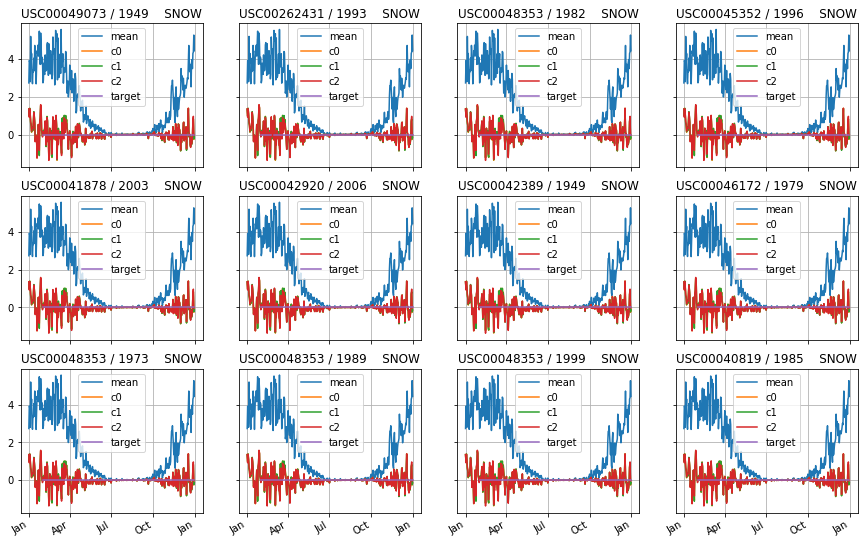

In [18]:
plot_recon_grid(rows)

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

./lib\Eigen_decomp.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  _residuals=np.insert(_residuals,0,residual_var[0]/total_energy)
./lib\Eigen_decomp.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  _percent_explained=np.insert(_percent_explained,0,percent_explained[0]/total_energy)


residual normalized norm  after mean: inf
residual normalized norm  after mean + top eigs: [ 0.02454575  0.02458486  0.02378089]


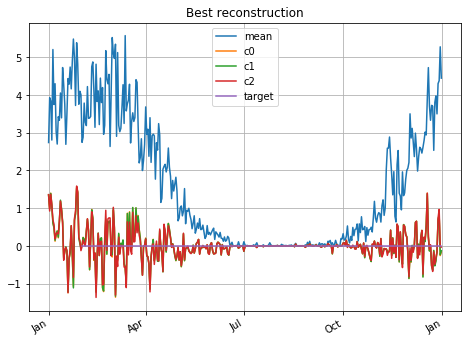

The installed widget Javascript is the wrong version.


In [19]:
row=rows[0]
target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

### What is the distribution of the residuals and the coefficients?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [20]:
# A function for plotting the CDF of a given feature
def plot_CDF(feat):
    rows=df3.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('number of instances')
    xlabel(feat)
    grid()

ValueError: x and y must have same first dimension, but have shapes (421,) and (420,)

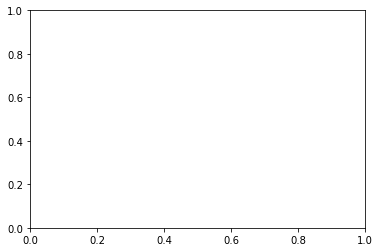

In [30]:
plot_CDF('res_2')

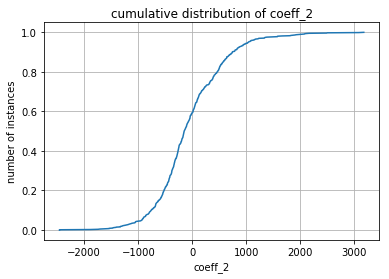

In [22]:
plot_CDF('coeff_2')

In [21]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename+'tobsc1')

Py4JJavaError: An error occurred while calling o98.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply$mcV$sp(FileFormatWriter.scala:147)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:57)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:121)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:101)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:58)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:56)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.doExecute(commands.scala:74)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$execute$1.apply(SparkPlan.scala:114)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeQuery$1.apply(SparkPlan.scala:135)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:132)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:113)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:87)
	at org.apache.spark.sql.execution.datasources.DataSource.write(DataSource.scala:492)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:215)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:198)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:494)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 32.0 failed 1 times, most recent failure: Lost task 2.0 in stage 32.0 (TID 1337, localhost, executor driver): java.io.IOException: (null) entry in command string: null chmod 0644 C:\Users\Sai\Documents\GitHub\CSE255-DSE230\Data\Weather\decon_SSSBSSBB_SNOW.parquettobsc1\_temporary\0\_temporary\attempt_20170515214929_0032_m_000002_0\part-00002-3560ccda-f497-42dd-9440-0b3ef82701ed.snappy.parquet
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:770)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:866)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:849)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:733)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:225)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:223)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:312)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:283)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:145)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.<init>(FileFormatWriter.scala:234)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:182)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:129)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:128)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1.apply$mcV$sp(FileFormatWriter.scala:127)
	... 31 more
Caused by: java.io.IOException: (null) entry in command string: null chmod 0644 C:\Users\Sai\Documents\GitHub\CSE255-DSE230\Data\Weather\decon_SSSBSSBB_SNOW.parquettobsc1\_temporary\0\_temporary\attempt_20170515214929_0032_m_000002_0\part-00002-3560ccda-f497-42dd-9440-0b3ef82701ed.snappy.parquet
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:770)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:866)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:849)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:733)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:225)
	at org.apache.hadoop.fs.RawLocalFileSystem$LocalFSFileOutputStream.<init>(RawLocalFileSystem.java:209)
	at org.apache.hadoop.fs.RawLocalFileSystem.createOutputStreamWithMode(RawLocalFileSystem.java:307)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:296)
	at org.apache.hadoop.fs.RawLocalFileSystem.create(RawLocalFileSystem.java:328)
	at org.apache.hadoop.fs.ChecksumFileSystem$ChecksumFSOutputSummer.<init>(ChecksumFileSystem.java:398)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:461)
	at org.apache.hadoop.fs.ChecksumFileSystem.create(ChecksumFileSystem.java:440)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:911)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:892)
	at org.apache.hadoop.fs.FileSystem.create(FileSystem.java:789)
	at org.apache.parquet.hadoop.ParquetFileWriter.<init>(ParquetFileWriter.java:223)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:312)
	at org.apache.parquet.hadoop.ParquetOutputFormat.getRecordWriter(ParquetOutputFormat.java:283)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetOutputWriter.<init>(ParquetOutputWriter.scala:37)
	at org.apache.spark.sql.execution.datasources.parquet.ParquetFileFormat$$anon$1.newInstance(ParquetFileFormat.scala:145)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$SingleDirectoryWriteTask.<init>(FileFormatWriter.scala:234)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.org$apache$spark$sql$execution$datasources$FileFormatWriter$$executeTask(FileFormatWriter.scala:182)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:129)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$$anonfun$write$1$$anonfun$3.apply(FileFormatWriter.scala:128)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [ ]:
!du -sh $data_dir/*.parquet